In [5]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing import image
from keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# Load from functions.py
from functions import load_muba_data, make_predictions, create_mixup_images, find_boundary_points

In [6]:
MUBA_ITERS = 60

dir_path = "Alzheimer's Disease"
IMAGE_SHAPE = (224, 224)
random_sample = 1

In [7]:
files = []
ground_truth = []
labels_A = []
images_A = []
labels_B = []
images_B = []

# Read the folders folders
directories = os.listdir(dir_path)

# Read files for each directory
for folder in directories:
        
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    ground_truth.extend([folder for _ in fileList])
    files.extend(fileList)

# Encode class values as integers    
encoder = LabelEncoder()
encoder.fit(ground_truth)
encoded_Y = encoder.transform(ground_truth)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 2)

ground_truth = np.array(dummy_y)

# Split the data into testing, training and validation data
# As using a random sample = 1, the testing set is the same as used for the model.
x_train, x_tv, y_train, y_tv = train_test_split(files, ground_truth, test_size=.05, random_state = random_sample) 
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample) 
x_test_A, x_test_B, y_test_A, y_test_B = train_test_split(x_test, y_test, test_size=.7, random_state = random_sample) # Have 2 test sets

print(len(x_test_A), len(x_test_B), len(x_val), len(x_train))

for file, label in zip(x_test_A, y_test_A):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images_A.append(img_array)
    labels_A.append(label)

for file, label in zip(x_test_B, y_test_B):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images_B.append(img_array)
    labels_B.append(label)

print(f"Classes are {encoder.classes_}")

48 112 160 6080
Classes are ['Demented' 'NonDem']


In [8]:
model_A = keras.models.load_model("basic_model_mixup_3.h5")

# Load model with final hidden layer activations
temp_model = tf.keras.Model(model_A.input,model_A.layers[-2].output)

As a check that the correct data is being used - run evaluation again and check it matches that of training.

In [9]:
model_A.evaluate(np.stack(images_A),np.stack(labels_A))

2/2 [==============================] - 5s 1s/step - loss: 0.1170 - categorical_accuracy: 0.9792


[0.11695706844329834, 0.9791666865348816]

In [10]:
final_layers, predictions, pred_array = make_predictions(images_A, model_A, temp_model)

2/2 [==============================] - 5s 999ms/step
[[1.1294700e-03 9.9887055e-01]
 [3.8711096e-05 9.9996126e-01]
 [9.6054286e-01 3.9457176e-02]
 [2.6548373e-02 9.7345155e-01]
 [9.4853580e-01 5.1464159e-02]]
[1, 1, 0, 1, 0]


In [11]:
initial_df = pd.DataFrame()
initial_df["class"] = [label[1] for label in labels_A] # 0 if demented, 1 if not
initial_df["image_index"] = [i for i in range(len(images_A))]
initial_df["confidence_class_0"] = [alpha[0] for alpha in predictions]
initial_df["confidence_class_1"] = [alpha[1] for alpha in predictions]

In [12]:
class_zero_df = initial_df[initial_df["class"] == 0] # demented
class_one_df = initial_df[initial_df["class"] == 1]
class_one_length = len(class_one_df)
class_zero_length = len(class_zero_df)

In [13]:
muba_df = create_mixup_images(class_zero_df,class_one_df,images_A,MUBA_ITERS)

In [14]:
muba_final_layers, muba_prediction, muba_prediction_proper = make_predictions(muba_df["mixup_image"], model_A, temp_model)

1073/1073 [==============================] - 3384s 3s/step
[[0.0011474  0.9988526 ]
 [0.00247795 0.99752206]
 [0.00400292 0.9959971 ]
 [0.0049897  0.99501026]
 [0.01084487 0.9891551 ]]
[1, 1, 1, 1, 1]


In [15]:
muba_df["argmax_pred"] = muba_prediction_proper # Adds predictions to muba dataframe


In [16]:
muba_df.head()

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred
0,0.000485,0.999515,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1
1,0.026167,0.973833,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1
2,0.044783,0.955217,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1
3,0.053690,0.946310,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1
4,0.079891,0.920109,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1


In [17]:
muba_final_layers_array = [x for x in muba_final_layers]
muba_df["final_layer"] = muba_final_layers_array

In [18]:
muba_predication_array = [x for x in muba_prediction]
muba_df["pred"] = muba_predication_array

In [19]:
muba_df.head()

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred,final_layer,pred
0,0.000485,0.999515,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 2.0958288, 2.4681816, 0.0, 0.337634...","[0.001147401, 0.9988526]"
1,0.026167,0.973833,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.9457483, 2.0841599, 0.051531076, ...","[0.0024779544, 0.99752206]"
2,0.044783,0.955217,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8622143, 1.8330624, 0.12172425, 0...","[0.004002916, 0.9959971]"
3,0.053690,0.946310,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8238914, 1.7218988, 0.15239292, 0...","[0.0049897046, 0.99501026]"
4,0.079891,0.920109,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.6614745, 1.351681, 0.32469457, 0....","[0.010844872, 0.9891551]"


In [20]:
boundary_points_df = find_boundary_points(muba_df, MUBA_ITERS)

In [21]:
boundary_final_layers, boundary_prediction, boundary_prediction_proper = make_predictions(boundary_points_df["mixup_image"], model_A, temp_model)
boundary_points_df["argmax_pred"] = boundary_prediction_proper

20/20 [==============================] - 65s 3s/step
[[0.5017521  0.49824792]
 [0.5013416  0.49865845]
 [0.49985102 0.50014895]
 [0.5085238  0.49147615]
 [0.509311   0.49068904]]
[0, 0, 1, 0, 0]


In [22]:
boundary_final_layers_array = [x for x in boundary_final_layers]
boundary_points_df["final_layer"] = boundary_final_layers_array

In [23]:
boundary_predication_array = [x for x in boundary_prediction]
boundary_points_df["pred"] = boundary_predication_array

In [24]:
boundary_points_df.head()

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred,final_layer,pred
0,0.502381,0.497619,"30 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0...","30 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.23325974, 0.0, 0.0...","[0.5017521, 0.49824792]"
1,0.512135,0.487865,"91 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0...","91 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.19905812, 0.0, 0.0...","[0.5013416, 0.49865845]"
2,0.602348,0.397652,"156 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","156 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.25865895, 0.0, 0.0...","[0.49985102, 0.50014895]"
3,0.567869,0.432131,"214 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","214 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0712716, 0.0, 0.0,...","[0.5085238, 0.49147615]"
4,0.651903,0.348097,"279 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","279 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.15186912, 0.0, 0.0...","[0.509311, 0.49068904]"


In [25]:
df = pd.concat([muba_df,boundary_points_df],axis=0,ignore_index=True)

In [26]:
df["test_set"] = ["A"] * len(df)

In [27]:
df.head(-5)

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred,final_layer,pred,test_set
0,0.000485,0.999515,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 2.0958288, 2.4681816, 0.0, 0.337634...","[0.001147401, 0.9988526]",A
1,0.026167,0.973833,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.9457483, 2.0841599, 0.051531076, ...","[0.0024779544, 0.99752206]",A
2,0.044783,0.955217,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8622143, 1.8330624, 0.12172425, 0...","[0.004002916, 0.9959971]",A
3,0.053690,0.946310,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8238914, 1.7218988, 0.15239292, 0...","[0.0049897046, 0.99501026]",A
4,0.079891,0.920109,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.6614745, 1.351681, 0.32469457, 0....","[0.010844872, 0.9891551]",A
...,...,...,...,...,...,...,...,...,...,...,...
34949,0.702517,0.297483,"33762 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [...","33762 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.350053, 0.0, 0.0, ...","[0.50153023, 0.49846977]",A
34950,0.767460,0.232540,"33826 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [...","33826 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5739886, 0.0, 0.0,...","[0.49516648, 0.5048335]",A
34951,0.605662,0.394338,"33876 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [...","33876 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.3162529, 0.0, 0.0,...","[0.4986201, 0.50137997]",A
34952,0.534007,0.465993,"33932 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [...","33932 [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",boundary,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.3664859, 0.0, 0.0,...","[0.50015366, 0.49984634]",A


In [28]:
for image,label,argmax_pred, final_layer, pred in zip(images_A,labels_A,pred_array, final_layers, predictions):
    row = pd.DataFrame([({ "alpha_class_0": None, # row 0 is multiplied by lam
                    "alpha_class_1": None,
                    "image_0": None,
                    "image_1":None,
                    "mixup_image": image,
                    "type":"orig",
                    "label":np.argmax(label),
                    "argmax_pred":argmax_pred,
                    "final_layer": final_layer,
                    "pred": predictions,
                    "test_set": "A"
                    })])
    df = pd.concat([df, row],axis=0, ignore_index=True)

In [29]:
df.head(-5)

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred,final_layer,pred,test_set
0,0.000485,0.999515,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 2.0958288, 2.4681816, 0.0, 0.337634...","[0.001147401, 0.9988526]",A
1,0.026167,0.973833,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.9457483, 2.0841599, 0.051531076, ...","[0.0024779544, 0.99752206]",A
2,0.044783,0.955217,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8622143, 1.8330624, 0.12172425, 0...","[0.004002916, 0.9959971]",A
3,0.05369,0.94631,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8238914, 1.7218988, 0.15239292, 0...","[0.0049897046, 0.99501026]",A
4,0.079891,0.920109,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.6614745, 1.351681, 0.32469457, 0....","[0.010844872, 0.9891551]",A
...,...,...,...,...,...,...,...,...,...,...,...
34997,None,None,None,None,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",orig,1,1,"[0.0, 0.0, 0.6451787, 1.1751235, 0.0, 0.656148...","[[0.00112947, 0.99887055], [3.8711096e-05, 0.9...",A
34998,None,None,None,None,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",orig,0,0,"[1.3811048, 1.5115747, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.00112947, 0.99887055], [3.8711096e-05, 0.9...",A
34999,None,None,None,None,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",orig,0,1,"[0.0, 0.0, 0.76171815, 1.2734926, 1.8940988, 1...","[[0.00112947, 0.99887055], [3.8711096e-05, 0.9...",A
35000,None,None,None,None,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",orig,0,0,"[1.379089, 1.0930469, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00112947, 0.99887055], [3.8711096e-05, 0.9...",A


In [30]:
# Test Set B
df_B = pd.DataFrame()

final_layers_B, predictions_B, pred_array_B = make_predictions(images_B, model_A, temp_model)

for image,label,argmax_pred, final_layer, pred in zip(images_B,labels_B,pred_array_B, final_layers_B, predictions_B):
    row = pd.DataFrame([({ "alpha_class_0": None, # row 0 is multiplied by lam
                    "alpha_class_1": None,
                    "image_0": None,
                    "image_1":None,
                    "mixup_image": image,
                    "type":"orig",
                    "label":np.argmax(label),
                    "argmax_pred":argmax_pred,
                    "final_layer": final_layer,
                    "pred": predictions,
                    "test_set": "B",
                    })])
    df_B = pd.concat([df_B, row],axis=0, ignore_index=True)

4/4 [==============================] - 10s 2s/step
[[9.9734560e-02 9.0026546e-01]
 [1.1497691e-02 9.8850238e-01]
 [1.0549827e-01 8.9450175e-01]
 [8.4679508e-01 1.5320487e-01]
 [9.8949915e-04 9.9901044e-01]]
[1, 1, 1, 0, 1]


In [31]:
df = pd.concat([df, df_B],axis=0, ignore_index=True)

In [32]:
df.head(-5)

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred,final_layer,pred,test_set
0,0.000485,0.999515,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 2.0958288, 2.4681816, 0.0, 0.337634...","[0.001147401, 0.9988526]",A
1,0.026167,0.973833,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.9457483, 2.0841599, 0.051531076, ...","[0.0024779544, 0.99752206]",A
2,0.044783,0.955217,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8622143, 1.8330624, 0.12172425, 0...","[0.004002916, 0.9959971]",A
3,0.05369,0.94631,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8238914, 1.7218988, 0.15239292, 0...","[0.0049897046, 0.99501026]",A
4,0.079891,0.920109,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.6614745, 1.351681, 0.32469457, 0....","[0.010844872, 0.9891551]",A
...,...,...,...,...,...,...,...,...,...,...,...
35109,None,None,None,None,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",orig,0,0,"[0.7433584, 1.6584771, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.00112947, 0.99887055], [3.8711096e-05, 0.9...",B
35110,None,None,None,None,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",orig,1,1,"[0.0, 0.0, 0.65879965, 0.94236535, 0.0, 1.7776...","[[0.00112947, 0.99887055], [3.8711096e-05, 0.9...",B
35111,None,None,None,None,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",orig,1,1,"[0.0, 0.0, 1.3409486, 0.8786476, 0.099930525, ...","[[0.00112947, 0.99887055], [3.8711096e-05, 0.9...",B
35112,None,None,None,None,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",orig,0,0,"[1.5372015, 0.9790137, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.00112947, 0.99887055], [3.8711096e-05, 0.9...",B


In [33]:
muba_projections = TSNE(2,random_state=1).fit_transform(
    np.concatenate([muba_final_layers, boundary_final_layers, final_layers, final_layers_B])
    )

In [34]:
df["projection_x"] = [x[0] for x in muba_projections]
df["projection_y"] = [x[1] for x in muba_projections]

In [35]:
df_to_save = df.drop(columns=["image_0","image_1","mixup_image"])

In [36]:
df_to_save.to_csv("muba_df_v5.csv")

In [37]:
#df = pd.read_csv("muba_df_v5.csv")

In [38]:
df.head()

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred,final_layer,pred,test_set,projection_x,projection_y
0,0.000485,0.999515,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 2.0958288, 2.4681816, 0.0, 0.337634...","[0.001147401, 0.9988526]",A,118.241608,25.717348
1,0.026167,0.973833,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.9457483, 2.0841599, 0.051531076, ...","[0.0024779544, 0.99752206]",A,115.145241,23.157675
2,0.044783,0.955217,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8622143, 1.8330624, 0.12172425, 0...","[0.004002916, 0.9959971]",A,111.796829,21.314171
3,0.05369,0.94631,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8238914, 1.7218988, 0.15239292, 0...","[0.0049897046, 0.99501026]",A,110.843460,20.970688
4,0.079891,0.920109,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.6614745, 1.351681, 0.32469457, 0....","[0.010844872, 0.9891551]",A,105.234398,17.780855


In [39]:
true_images_df = df[df["type"] == "orig"]

true_images_A_df = true_images_df[true_images_df["test_set"] == "A"]
true_images_B_df = true_images_df[true_images_df["test_set"] == "B"]

mixup_images_df =  df[df["type"] == "mix"]
boundary_images_df = df[df["type"] == "boundary"]

In [40]:
true_A_class_0 = true_images_A_df[true_images_A_df["label"] == 0]
true_A_class_1 = true_images_A_df[true_images_A_df["label"] == 1]

true_B_class_0 = true_images_B_df[true_images_B_df["label"] == 0]
true_B_class_1 = true_images_B_df[true_images_B_df["label"] == 1]

mixup_class_0 = mixup_images_df[mixup_images_df["label"] == 0]
mixup_class_1 = mixup_images_df[mixup_images_df["label"] == 1]

true_A_errors = true_images_A_df[true_images_A_df["label"] != true_images_A_df["argmax_pred"]]
true_B_errors = true_images_B_df[true_images_B_df["label"] != true_images_B_df["argmax_pred"]]
mixup_errors = mixup_images_df[mixup_images_df["label"] != mixup_images_df["argmax_pred"]]

error_free_true_class_A = true_A_class_0[true_A_class_0["label"] == true_A_class_0["argmax_pred"]]
error_free_true_class_B = true_A_class_1[true_A_class_1["label"] == true_A_class_1["argmax_pred"]]
error_free_mixup_class_A = mixup_class_0[mixup_class_0["label"] == mixup_class_0["argmax_pred"]]
error_free_mixup_class_B = mixup_class_1[mixup_class_1["label"] == mixup_class_1["argmax_pred"]]

In [41]:
mixup_images_df.head()

,alpha_class_0,alpha_class_1,image_0,image_1,mixup_image,type,label,argmax_pred,final_layer,pred,test_set,projection_x,projection_y
0,0.000485,0.999515,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 2.0958288, 2.4681816, 0.0, 0.337634...","[0.001147401, 0.9988526]",A,118.241608,25.717348
1,0.026167,0.973833,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.9457483, 2.0841599, 0.051531076, ...","[0.0024779544, 0.99752206]",A,115.145241,23.157675
2,0.044783,0.955217,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8622143, 1.8330624, 0.12172425, 0...","[0.004002916, 0.9959971]",A,111.796829,21.314171
3,0.05369,0.94631,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.8238914, 1.7218988, 0.15239292, 0...","[0.0049897046, 0.99501026]",A,110.843460,20.970688
4,0.079891,0.920109,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",mix,1,1,"[0.0, 0.0, 1.6614745, 1.351681, 0.32469457, 0....","[0.010844872, 0.9891551]",A,105.234398,17.780855


In [42]:
def plot_projections(colour_by_alpha: bool = True,
                     include_errors: bool = True,
                     outline_errors: bool = True,
                     show_boundary_points: bool = True,
                     scale_errors: bool = False,
                     colour_boundaries_by_alpha: bool = False,
                     include_type_B: bool = False
                     ):
    
    a=None
    fig, ax = plt.subplots(figsize=(14, 10))

    # Combine two colour maps
    colors1 = plt.cm.Reds_r(np.linspace(0., 1, 128))
    colors2 = plt.cm.Blues(np.linspace(0, 1, 128))

    # Build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    # Plot mixup points
    if colour_by_alpha:
        ax.scatter(error_free_mixup_class_A["projection_x"],error_free_mixup_class_A["projection_y"],marker="o",s=10,c = error_free_mixup_class_A["alpha_class_0"],cmap = "Reds",vmin=0.5,vmax=1)
        ax.scatter(error_free_mixup_class_B["projection_x"],error_free_mixup_class_B["projection_y"],marker="o",s=10,c = error_free_mixup_class_B["alpha_class_0"],cmap = "Blues_r", label = "Mix-up",vmin=0,vmax=0.5)

    # Plot mixup errors
    if include_errors:

        if colour_by_alpha:
            ax.scatter(mixup_errors["projection_x"],mixup_errors["projection_y"],marker="o",s = (mixup_errors["min_alpha"]*7)**4 if scale_errors else 20 ,c = mixup_errors["alpha_class_0"],cmap = mymap, edgecolors="black",label="Mix-up Incorrect Prediction",vmin=0,vmax=1)
        elif not colour_by_alpha:
            ax.scatter(mixup_class_0["projection_x"],mixup_class_0["projection_y"],marker="o",s=20,color = "salmon",label="Mix-up Class Demented")
            ax.scatter(mixup_class_1["projection_x"],mixup_class_1["projection_y"],marker="o",s=20,color = "deepskyblue",label="Mix-up Class Non-Demented")
            ax.scatter(mixup_errors["projection_x"],mixup_errors["projection_y"],marker="o",s=20,color="None",edgecolors = "black" if outline_errors else None,label="Mix-up Incorrect Prediction")
    
    elif not include_errors:
        if not colour_by_alpha:
            ax.scatter(error_free_mixup_class_A["projection_x"],error_free_mixup_class_A["projection_y"],marker="o",s=10,color = "salmon",label="Mix-up Class Demented")
            ax.scatter(error_free_mixup_class_B["projection_x"],error_free_mixup_class_B["projection_y"],marker="o",s=10,color = "deepskyblue",label="Mix-up Class Non Demented")

    # Plot normal points
    ax.scatter(true_A_class_0["projection_x"],true_A_class_0["projection_y"],marker="^",s=50,color="red",label="True Class Demented")
    ax.scatter(true_A_class_1["projection_x"],true_A_class_1["projection_y"],marker="^",s=50,color="blue",label="True Class Non Demented")
    ax.scatter(true_A_errors["projection_x"],true_A_errors["projection_y"],marker="^",s=50,color="None",edgecolors = "black",label="Incorrect Prediction",)

    if show_boundary_points:
        ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"],marker="o",s=20,c="green" if not colour_boundaries_by_alpha else boundary_images_df["alpha_class_0"],cmap = mymap if colour_boundaries_by_alpha else None, vmin = 0, vmax = 1 ,label="Boundary Points", edgecolors = "black" if colour_boundaries_by_alpha else None)
    
    if include_type_B:
        ax.scatter(true_B_class_0["projection_x"],true_B_class_0["projection_y"],marker="^",s=50,color="yellow",label="True Class Demented - Test Set B")
        ax.scatter(true_B_class_1["projection_x"],true_B_class_1["projection_y"],marker="^",s=50,color="purple",label="True Class Non Demented - Test Set B")
        ax.scatter(true_B_errors["projection_x"],true_B_errors["projection_y"],marker="^",s=50,color="None",edgecolors = "black",label="Incorrect Prediction",)

    ax.legend()

    ax.set_title("t-SNE Dimension Analysis")

    if colour_by_alpha or colour_boundaries_by_alpha or include_errors:
        a = ax.scatter([0,1],[0,1],s=0,vmin=0,vmax=1,c=[0,1],cmap=mymap)
        plt.colorbar(a,label = "Class Demented Alpha Value")
    

    plt.show()

C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_23688\3907722545.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"],marker="o",s=20,c="green" if not colour_boundaries_by_alpha else boundary_images_df["alpha_class_0"],cmap = mymap if colour_boundaries_by_alpha else None, vmin = 0, vmax = 1 ,label="Boundary Points", edgecolors = "black" if colour_boundaries_by_alpha else None)


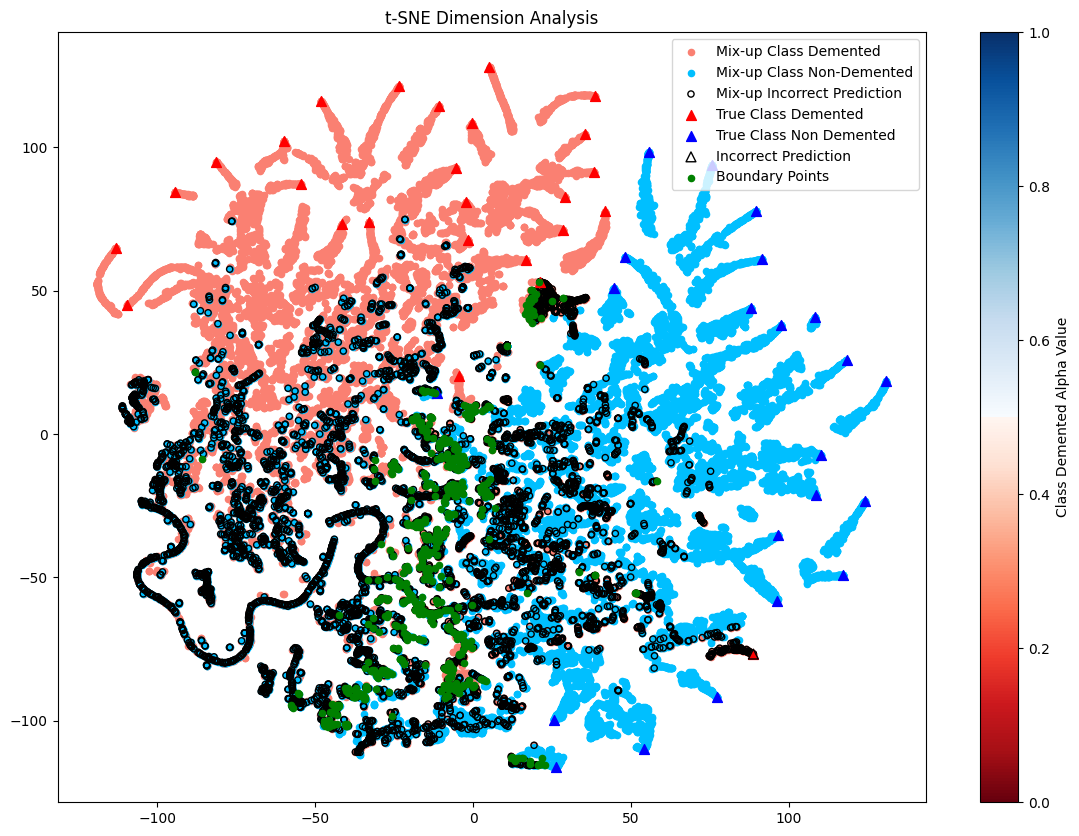

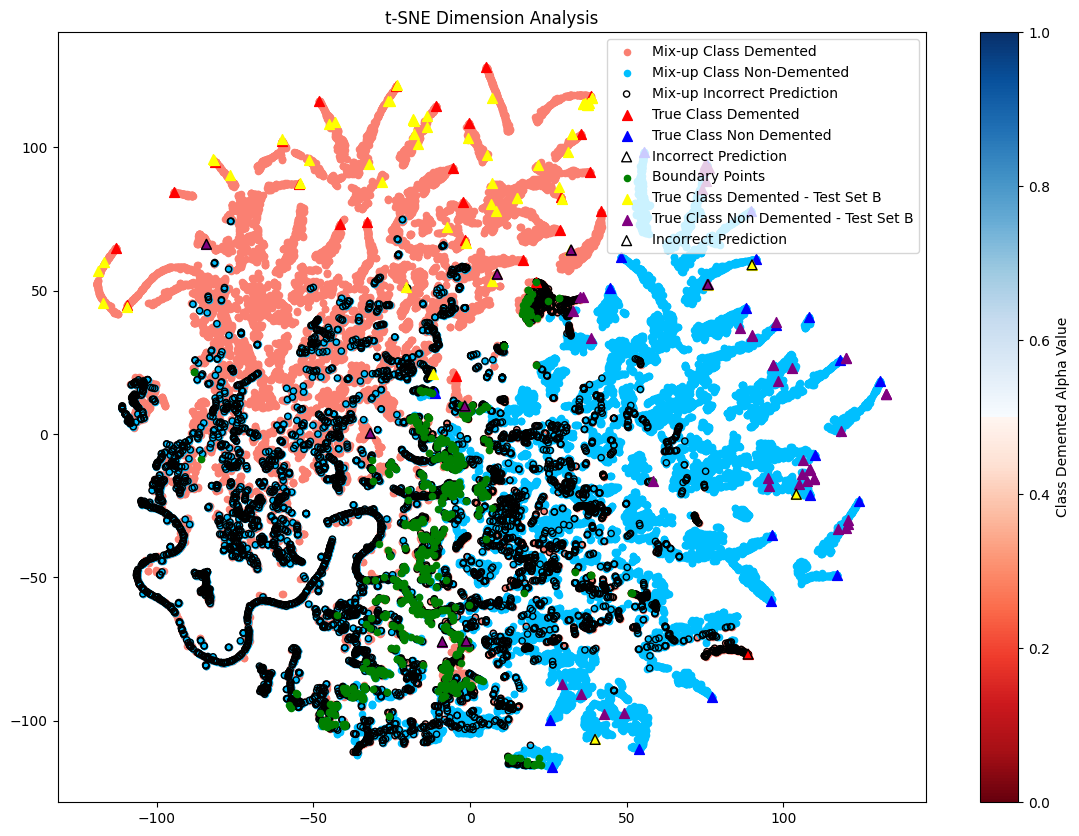

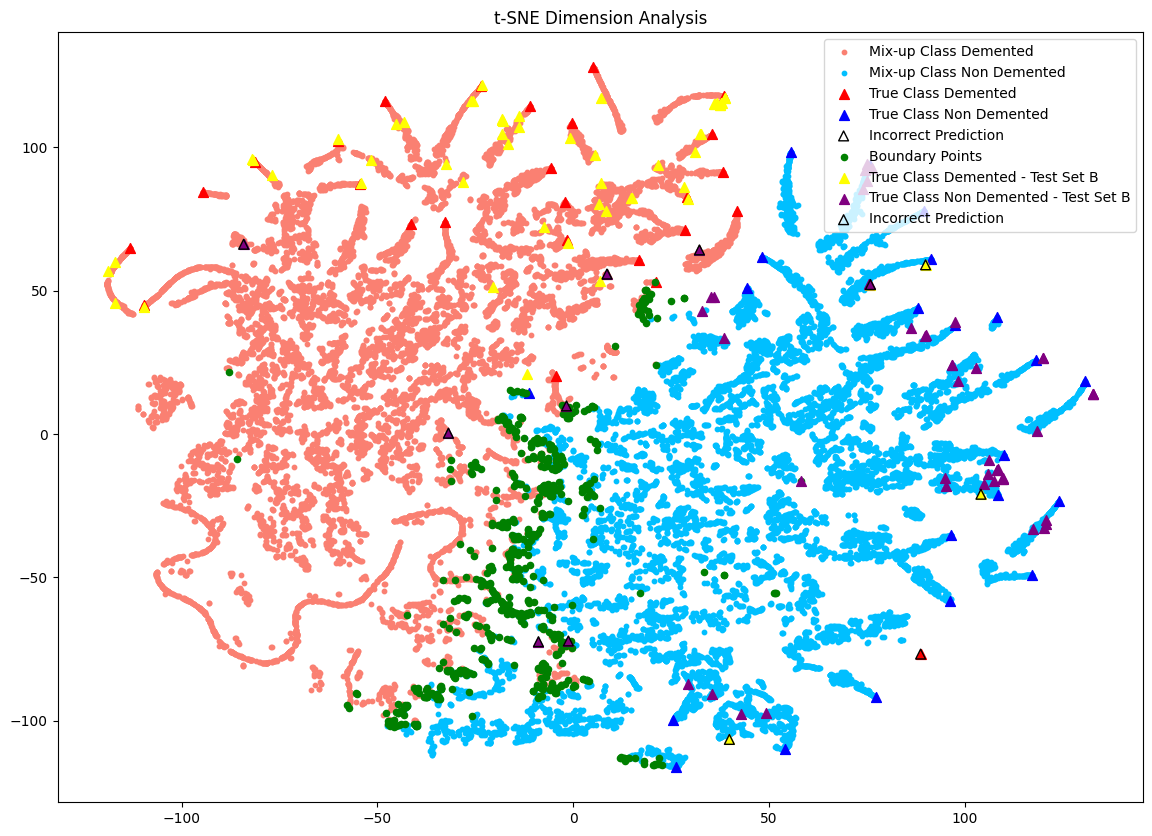

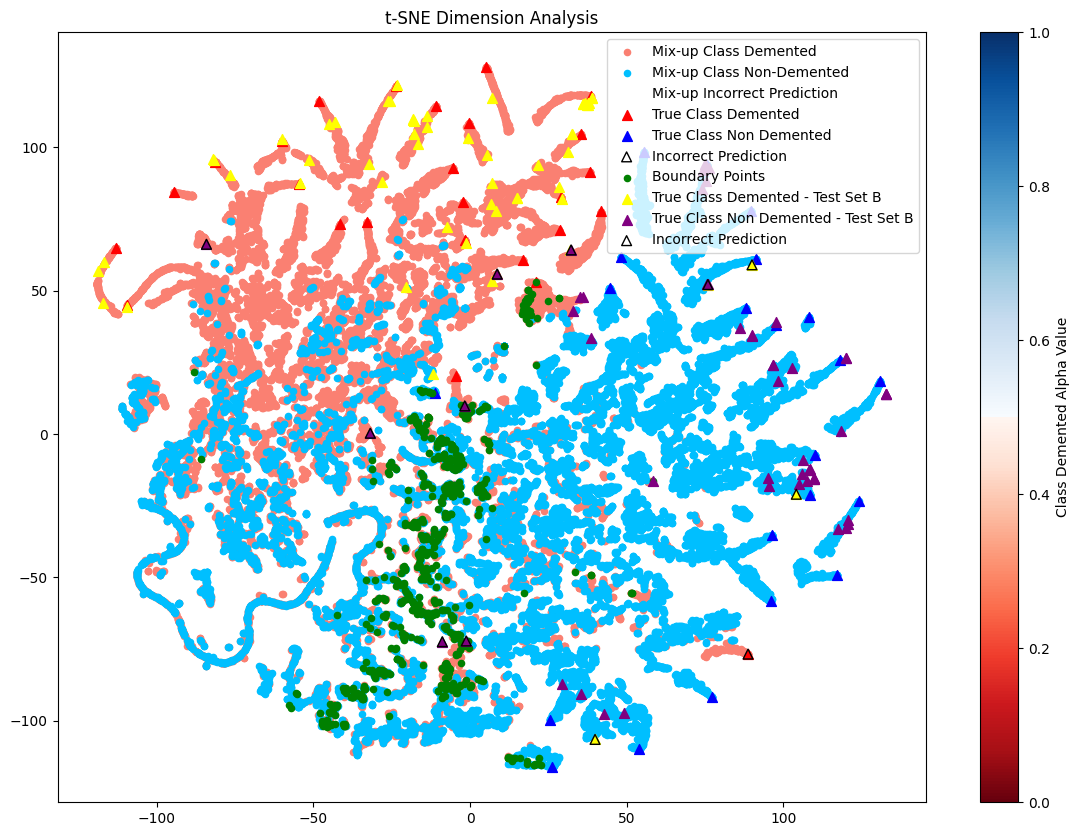

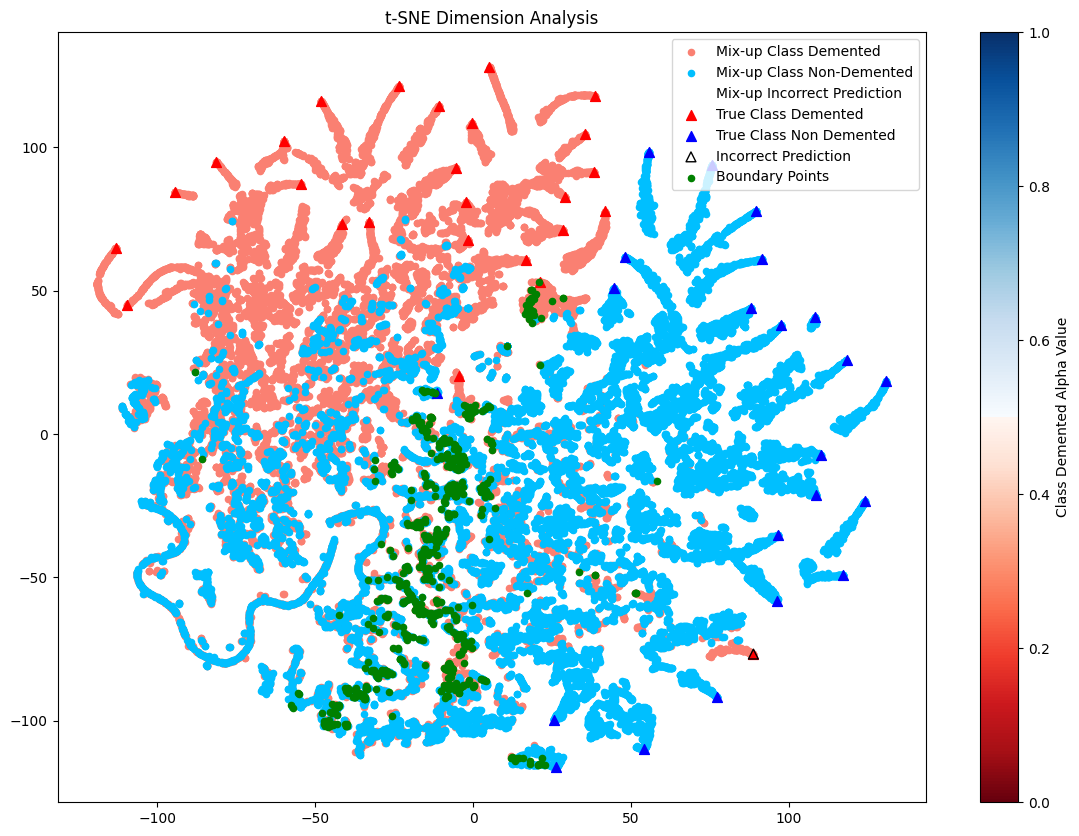

In [43]:
plot_projections(False,True,True,True,False,False)
plot_projections(False,True,True,True,False,False,True)
plot_projections(False,False,False,True,False,False,True)
plot_projections(False,True,False,True,False,False,True)
plot_projections(False,True,False,True,False,False,False)

Text(0.5, 1.0, 'Test Data')

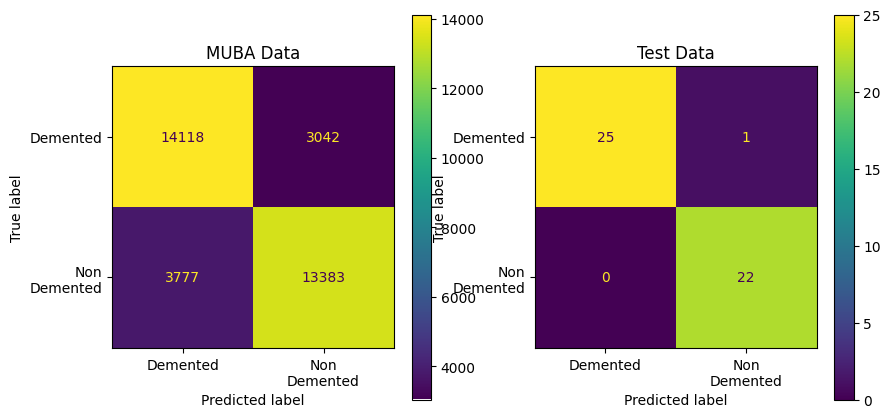

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, axs = plt.subplots(1,2, figsize = (10,5))
cm_muba = confusion_matrix([x for x in mixup_images_df["label"]],[y for y in mixup_images_df["argmax_pred"]])
cm_test = confusion_matrix([x for x in true_images_A_df["label"]],[y for y in true_images_A_df["argmax_pred"]])

cm_muba_display = ConfusionMatrixDisplay(confusion_matrix = cm_muba, display_labels=["Demented","Non\nDemented"])
cm_test_display = ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels=["Demented","Non\nDemented"])

cm_muba_display.plot(ax = axs[0])
cm_test_display.plot(ax = axs[1])

axs[0].set_title("MUBA Data")
axs[1].set_title("Test Data")

Text(0.5, 1.0, 'Boundary Distribution Curve')

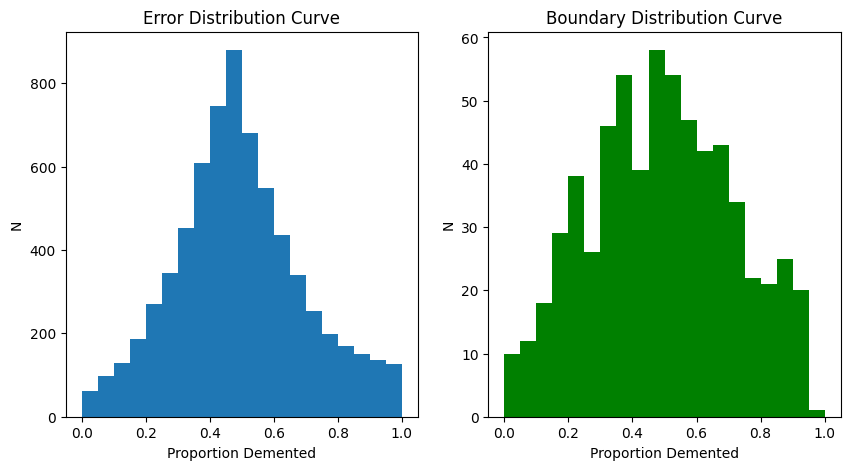

In [63]:
fig, axs = plt.subplots(1,2, figsize = (10,5))

axs[0].hist(mixup_errors["alpha_class_0"],bins = [0.05*i for i in range(21)])
axs[0].set_ylabel("N")
axs[0].set_xlabel("Proportion Demented")
axs[0].set_title("Error Distribution Curve")

axs[1].hist(boundary_images_df["alpha_class_0"],[0.05*i for i in range(21)],color="green")
axs[1].set_ylabel("N")
axs[1].set_xlabel("Proportion Demented")
axs[1].set_title("Boundary Distribution Curve")

Text(0.5, 1.0, 'Confusion Matrix for Test Set B')

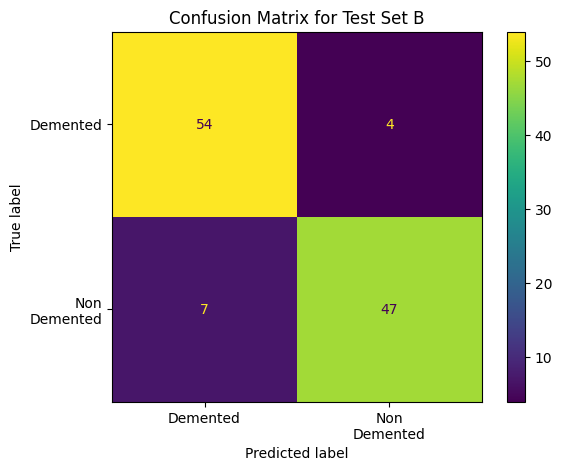

In [46]:
cm_B = confusion_matrix([x for x in true_images_B_df["label"]],[y for y in true_images_B_df["argmax_pred"]])
cm_muba_display = ConfusionMatrixDisplay(confusion_matrix = cm_B, display_labels=["Demented","Non\nDemented"])
cm_muba_display.plot()
plt.title("Confusion Matrix for Test Set B")

In [47]:
final_layers_true_images = true_images_df["final_layer"]
final_layers_true_images_B = true_images_B_df["final_layer"]

test_set_A = df[df["test_set"] == "A"]
test_set_B = df[df["test_set"] == "B"]
final_layers_all_images = test_set_A["final_layer"]

In [48]:
from scipy import spatial


final_layers_all_images_arr = [vector for vector in final_layers_all_images]
final_layers_only_mixup_arr = [vector for vector in test_set_A[test_set_A["type"] == "mix" ]["final_layer"] ]
final_layers_all_boundaries_arr = [vector for vector in test_set_A[test_set_A["type"] == "boundary" ]["final_layer"] ]
final_layers_true_images_B_arr = [vector for vector in final_layers_true_images_B]

if type(final_layers_all_images_arr[0]) == str:
    new_x = []
    for y in final_layers_all_images_arr:
        y = y.split(" ")
        new_y = []

        for val in y:
            if "\n" in val:
                val = val[0:-1]
            if "]" in val:
                val = val[0:-1]
            if "[" in val:
                val = val[1:]
            if not (val == ""):
                new_y.append(float(val))
        new_x.append(list(new_y))
    final_layers_all_images_arr = new_x

if type(final_layers_all_boundaries_arr[0]) == str:
    new_x = []
    for y in final_layers_all_boundaries_arr:
        y = y.split(" ")
        new_y = []

        for val in y:
            if "\n" in val:
                val = val[0:-1]
            if "]" in val:
                val = val[0:-1]
            if "[" in val:
                val = val[1:]
            if not (val == ""):
                new_y.append(float(val))
        new_x.append(list(new_y))
    final_layers_all_boundaries_arr = new_x

    new_x = []
    for y in final_layers_only_mixup_arr:
        y = y.split(" ")
        new_y = []

        for val in y:
            if "\n" in val:
                val = val[0:-1]
            if "]" in val:
                val = val[0:-1]
            if "[" in val:
                val = val[1:]
            if not (val == ""):
                new_y.append(float(val))
        new_x.append(list(new_y))
    final_layers_only_mixup_arr = new_x

    new_x = []
    for y in final_layers_true_images_B_arr:
        y = y.split(" ")
        new_y = []

        for val in y:
            if "\n" in val:
                val = val[0:-1]
            if "]" in val:
                val = val[0:-1]
            if "[" in val:
                val = val[1:]
            if not (val == ""):
                new_y.append(float(val))
        new_x.append(list(new_y))
    final_layers_true_images_B_arr = new_x


tree_As = spatial.KDTree(final_layers_all_images_arr)
tree_mix = spatial.KDTree(final_layers_only_mixup_arr)
tree_boundaries = spatial.KDTree(final_layers_all_boundaries_arr)
tree_Bs = spatial.KDTree(final_layers_true_images_B_arr)

distances_all = []
distances_mix = []
distances_A = []
distances_B = []
distance_boundaries = []
distance_boundaries_A = []
distance_boundaries_B = []
types = []
alphas = []

for vector, label in zip(final_layers_true_images_B, test_set_B["label"]):

    if type(vector) == str:
        v = vector.split(" ")
        new_v = []

        for val in v:
            if "\n" in val:
                val = val[0:-1]
            if "]" in val:
                val = val[0:-1]
            if "[" in val:
                val = val[1:]
            if not (val == ""):
                new_v.append(float(val))
        
        vector = new_v

    
    distance, id = tree_As.query(vector,p=2)
    distance_bound, id_bound = tree_boundaries.query(vector,p=2)
    distance_mix, id_mix = tree_mix.query(vector,p=2)

    row = test_set_A.loc[[id]]
    

    distances_all.append(distance)
    distance_boundaries.append(distance_bound)
    distances_mix.append(distance_mix)

    types.append(str(row["type"][id]))

    alpha = row["alpha_class_0"][id]
    if alpha == None:
        if int(row["label"]) == 0: #class 0, therefore alpha_class_0 = 1
            alpha = 1
        else:
            alpha = 0
    
    alphas.append(alpha)

    if label == 0:
        distances_A.append(distance)
        distance_boundaries_A.append(distance_bound)
    else:
        distances_B.append(distance)
        distance_boundaries_B.append(distance_bound)



In [49]:
print(np.mean(distances_A))
print(np.mean(distances_B))

0.7789809300812138
1.5548049440313687


In [50]:
print(np.mean(distance_boundaries_A))
print(np.mean(distance_boundaries_B))

3.909123282377154
5.578766507817937


In [51]:
incorrect_class_0_dist_to_bound = []
incorrect_class_1_dist_to_bound = []

for distance, label, pred, in zip(distance_boundaries, true_images_B_df["label"],true_images_B_df["argmax_pred"], ):
    
    if label != pred:
        if label == 0:
            incorrect_class_0_dist_to_bound.append(distance)
        elif label == 1:
            incorrect_class_1_dist_to_bound.append(distance)

print(f"Average shortest distance to boundary for incorrect class 0: {np.mean(incorrect_class_0_dist_to_bound)}")
print(f"Average shortest distance to boundary for incorrect class 1: {np.mean(incorrect_class_1_dist_to_bound)}")

Average shortest distance to boundary for incorrect class 0: 4.649781627597738
Average shortest distance to boundary for incorrect class 1: 1.3839055752072842


In [52]:
from collections import Counter
counts = Counter(types)
print(counts)

Counter({'mix': 97, 'orig': 14, 'boundary': 1})


In [53]:
av_distances = []

layer_array = [x for x in final_layers_true_images_B]

for i, vector in enumerate(layer_array):

    if type(vector) == str:
        v = vector.split(" ")
        new_v = []

        for val in v:
            if "\n" in val:
                val = val[0:-1]
            if "]" in val:
                val = val[0:-1]
            if "[" in val:
                val = val[1:]
            if not (val == ""):
                new_v.append(float(val))
        
        vector = new_v

    query = (tree_Bs.query(vector,p=2,k=2)[0][1])

    av_distances.append(query)

print(np.mean(av_distances))


1.2777065830167067


skew is: 0.9806453761926858


Text(0.5, 1.0, 'Minimum Distance Between Testset B and Mixup Points')

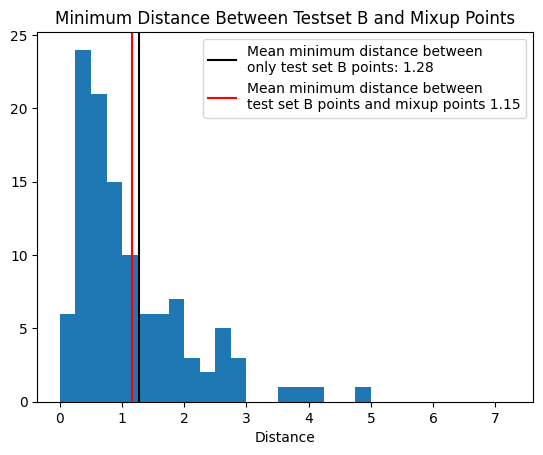

In [54]:
from scipy.stats import skew

fig,ax = plt.subplots(1,1)

ax.hist(distances_mix, bins = [0.25 * i for i in range(30)])

ax.axvline(np.mean(av_distances), color = "black", label = f"Mean minimum distance between\nonly test set B points: {round(np.mean(av_distances),2)}")
ax.axvline(np.mean(distances_mix), color = "red", label = f"Mean minimum distance between\ntest set B points and mixup points {round(np.mean(distances_mix),2)}")

ax.set_xlabel("Distance")
ax.legend()

print("skew is:",skew(av_distances) )

plt.title("Minimum Distance Between Testset B and Mixup Points")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


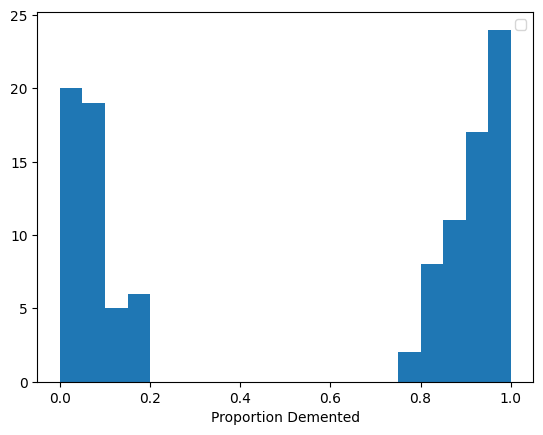

In [55]:
fig,ax = plt.subplots(1,1)

ax.hist([a for a in alphas if a is not None], bins = [0.05 * i for i in range(21)])
ax.set_xlabel("Proportion Demented")
ax.legend()

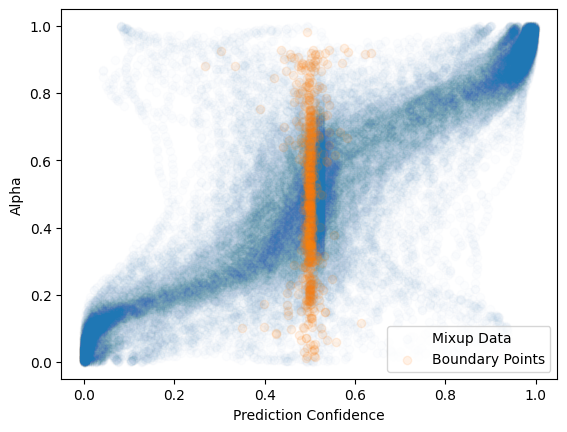

In [56]:
x1 = [pred[0] for pred in mixup_images_df["pred"]]
y1 = [a for a in mixup_images_df["alpha_class_0"]]

x2 = [pred[0] for pred in boundary_points_df["pred"]]
y2 = [a for a in boundary_points_df["alpha_class_0"]]

plt.scatter(x1,y1, alpha = 0.01, label = "Mixup Data")
plt.scatter(x2,y2, alpha = 0.1, label = "Boundary Points")

plt.xlabel("Prediction Confidence")
plt.ylabel("Alpha")
plt.legend()

In [57]:
boundary_images_boundary_1 = boundary_images_df[boundary_images_df["alpha_class_0"] > 0.3]

boundary_images_boundary_2 = boundary_images_df[boundary_images_df["alpha_class_0"] < 0.3]

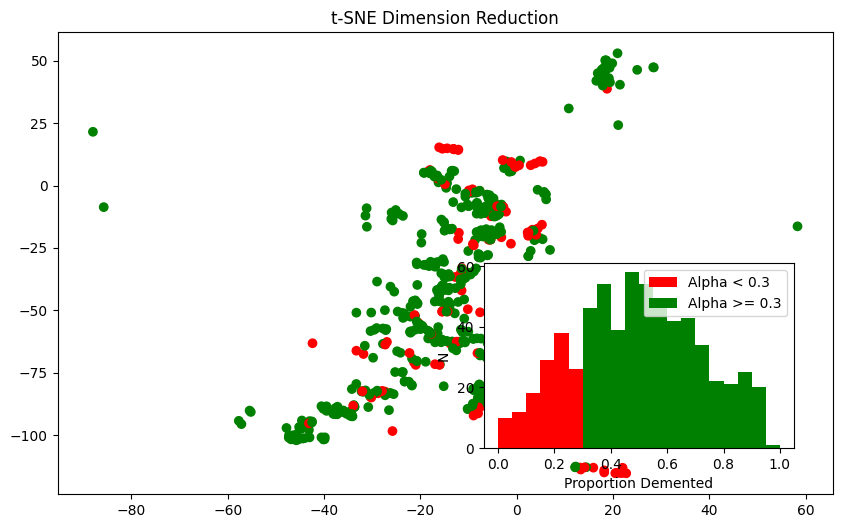

In [58]:
fig, ax = plt.subplots(1,1,figsize = (10,6))

ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], c = ["red" if a < 0.3 else "green" for a in boundary_images_df["alpha_class_0"] ])

ax2 = ax.inset_axes([0.55,0.1,0.4,0.4])
ax2.hist(boundary_images_boundary_2["alpha_class_0"],bins=[0.05*i for i in range(21)],color = "red", label = "Alpha < 0.3")
ax2.hist(boundary_images_boundary_1["alpha_class_0"],bins=[0.05*i for i in range(21)],color = "green", label = "Alpha >= 0.3")
ax2.set_xlabel("Proportion Demented")
ax2.set_ylabel("N")


ax.set_title("t-SNE Dimension Reduction")
ax2.legend()

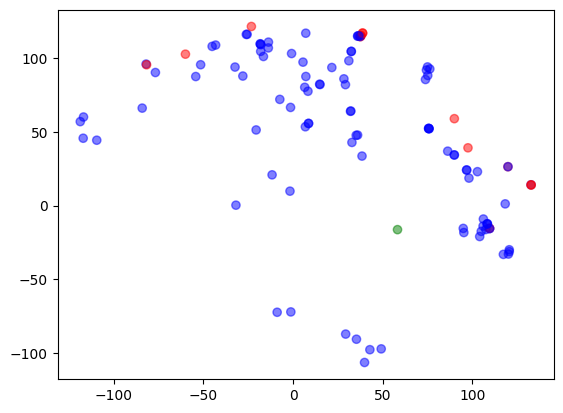

In [59]:
types_colors = []

for t in types:
    if t == "mix":
        types_colors.append("blue")
    elif t == "boundary":
        types_colors.append("green")
    elif t == "orig":
        types_colors.append("red")
    else:
        print(t)

plt.scatter(test_set_B["projection_x"],test_set_B["projection_y"],c=types_colors,alpha = 0.5)